## GRU를 이용한 IMDB리뷰 분류하기
1D CNN을 이용하여 IMDB 영화 리뷰 데이터를 분류해보겠습니다.

### 1. 데이터 로드 및 단어 토큰화

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import torch
from tqdm import tqdm
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
from google.colab import files
uploaded = files.upload()

Saving IMDB Dataset.csv to IMDB Dataset.csv


In [4]:
df = pd.read_csv('IMDB Dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


review 열과 sentiment 열 모두 non-null(결측값이 아닌) 데이터가 5만개로 확인되므로 결측값은 없습니다. 결측값을 확인할 수 있는 또 다른 방법인 .isnull().values.any()를 사용하여 결측값 여부를 확인합니다.

<Axes: xlabel='sentiment'>

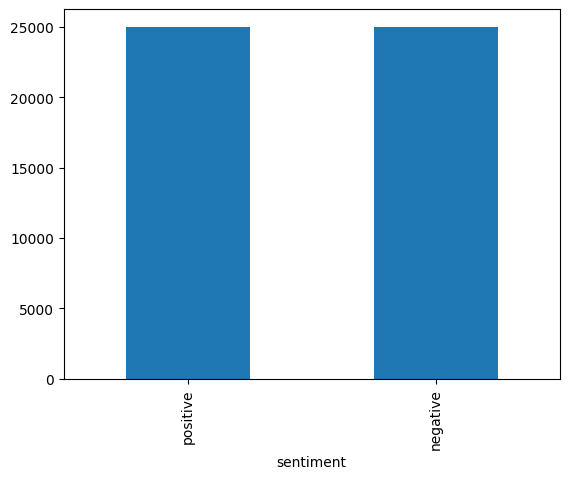

In [5]:
df['sentiment'].value_counts().plot(kind = 'bar')

두 레이블의 개수는 동일합니다. 레이블이 현재 'positive'와 'negative'로 구성되어져 있으므로 각각 1, 0으로 변환하고 정상 변환되었는지 확인하기 위해서 상위 5개의 행을 출력합니다.

In [6]:
df['sentiment'] = df['sentiment'].replace(['positive', 'negative'],[1,0])
df.head()

/tmp/ipython-input-6-4097363152.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sentiment'] = df['sentiment'].replace(['positive', 'negative'],[1,0])


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


 'review' 열은 X_data, 레이블에 해당하는 'sentiment' 열은 y_data에 저장 후 정상 변환 되었는지 확인하기 위해서 다시 한 번 개수를 출력합니다.

In [7]:
X_data = df['review']
y_data = df['sentiment']
print('영화 리뷰의 개수: {}'.format(len(X_data)))
print('영화 리뷰 레이블의 개수: {}'.format(len(y_data)))

영화 리뷰의 개수: 50000
영화 리뷰 레이블의 개수: 50000


훈련 데이터와 검증 데이터, 테스트 데이터로 데이터를 나눕니다. 우선 훈련 데이터와 테스트 데이터를 5:5 비율로 나누고, 훈련 데이터를 다시 8:2 비율로 훈련 데이터와 검증 데이터로 나눕니다. sklearn의 train_test_split은 데이터를 나눌 때 굉장히 많이 사용하는 도구이므로 꼭 기억해둡시다. 데이터를 나눌 때 레이블의 비율을 유지하고 싶다면 레이블 데이터를 stratify에 명시해줄 수 있습니다.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.5, stratify=y_data)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

print('--------훈련 데이터의 비율-----------')
print(f'부정 리뷰 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'긍정 리뷰 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')
print('--------검증 데이터의 비율-----------')
print(f'부정 리뷰 = {round(y_valid.value_counts()[0]/len(y_valid) * 100,3)}%')
print(f'긍정 리뷰 = {round(y_valid.value_counts()[1]/len(y_valid) * 100,3)}%')
print('--------테스트 데이터의 비율-----------')
print(f'부정 리뷰 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')
print(f'긍정 리뷰 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')

--------훈련 데이터의 비율-----------
부정 리뷰 = 50.0%
긍정 리뷰 = 50.0%
--------검증 데이터의 비율-----------
부정 리뷰 = 50.0%
긍정 리뷰 = 50.0%
--------테스트 데이터의 비율-----------
부정 리뷰 = 50.0%
긍정 리뷰 = 50.0%


 훈련 데이터, 검증 데이터, 테스트 데이터에 대해서 토큰화를 진행해봅시다. 토큰화를 위해 토큰화 함수 tokenize()를 구현하였습니다. 토큰화 진행 시에 선택적으로 소문자화를 진행하고 싶다면 소문자화도 진행할 수 있습니다. 파이썬 문자열에 .lower()를 사용하면 해당 문자열을 소문자로 바꿔줍니다. 해당 함수로 훈련 데이터, 검증 데이터, 테스트 데이터에 대해서 모두 토큰화를 진행합니다.

In [9]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [10]:
# 문장별 토큰화 및 소문자로 변환
def tokenize(sentences):
  tokenized_sentences= []
  for sent in tqdm(sentences):
    tokenized_sent = word_tokenize(sent)
    tokenized_sent = [word.lower() for word in tokenized_sent]
    tokenized_sentences.append(tokenized_sent)
  return tokenized_sentences

tokenized_X_train = tokenize(X_train)
tokenized_X_test = tokenize(X_test)
tokenized_X_valid = tokenize(X_valid)

100%|██████████| 5000/5000 [00:06<00:00, 725.87it/s]


토큰화가 진행된 후의 훈련 데이터의 상위 2개 샘플 출력해봅시다.

In [11]:
for sent in tokenized_X_train[:2]:
  print(sent)

['no', ',', 'no', ',', 'no', ',', 'no', ',', 'no', ',', 'no', ',', 'no', '!', 'this', 'is', 'not', 'a', 'film', ',', 'this', 'is', 'an', 'excuse', 'to', 'show', 'people', 'dancing', '.', 'this', 'is', 'just', 'not', 'good', '.', 'even', 'the', 'dancing', 'is', 'slow', 'and', 'not', 'half', 'as', 'entertaining', 'as', 'the', 'mediocre', "'dirty", 'dancing', "'", ',', 'let', 'alone', 'any', 'other', 'good', 'dance', 'movie.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'is', 'it', 'a', 'love', 'story', '?', 'is', 'it', 'a', 'musical', '?', 'is', 'it', 'a', 'drama', '?', 'is', 'it', 'a', 'comedy', '?', 'it', "'s", 'not', 'that', 'this', 'movie', 'is', 'a', 'bit', 'of', 'all', ',', 'it', "'s", 'that', 'this', 'movie', 'fails', 'at', 'everything', 'it', 'attempts', 'to', 'be', '.', 'the', 'film', 'turns', 'out', 'to', 'be', 'even', 'more', 'meaningless', 'as', 'the', 'film', 'progresses.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'acting', 'is', 'terrible', 'from', 'all', 'sides', ',', 'the'

##2. Vocab 만들기
이제 토큰화 된 훈련 데이터로부터 정수 인코딩을 진행하기 위한 단어 집합(Vocabulary)을 만들어봅시다. Counter 모듈을 사용하면 현재 갖고 있는 데이터에 존재하는 단어 종류의 총 개수와 각 단어에 대해서 등장 빈도를 카운트 할 수 있습니다.

In [12]:
word_list = []
for sent in tokenized_X_train:
  for word in sent:
    word_list.append(word)

word_counts = Counter(word_list)
print(f'단어 집합의 총 크기: {len(word_counts)}')

단어 집합의 총 크기: 100546


Counter 모듈을 통해 확인한 훈련 데이터에 존재하는 총 단어수는 100670개입니다. 이 100670는 단어들의 집합(set)에서의 단어의 개수를 의미하므로 훈련 데이터에 존재하는 총 단어의 종류의 개수입니다. 또한, 현재 word_counts에는 각 단어의 등장 빈도수가 기록되어져 있습니다. 영단어 'the'와 'love'의 등장 빈도수를 확인해봅시다.

In [13]:
print('훈련 데이터에서의 단어 the의 등장 횟수 :', word_counts['the'])
print('훈련 데이터에서의 단어 love의 등장 횟수 :', word_counts['love'])

훈련 데이터에서의 단어 the의 등장 횟수 : 265150
훈련 데이터에서의 단어 love의 등장 횟수 : 5155


단어의 등장 빈도수가 높은 순서대로 정렬하여 vocab이라는 변수에 저장한 후 빈도수가 가장 높은 상위 10개의 단어를 출력합니다.

In [14]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('등장 빈도수 상위 10개 단어')
print(vocab[:10])

등장 빈도수 상위 10개 단어
['the', ',', '.', 'and', 'a', 'of', 'to', 'is', '/', '>']


여기서는 빈도수가 낮은 단어들은 자연어 처리에서 배제하고자 합니다. 등장 빈도수가 3회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

In [15]:
threshold = 3
total_cnt = len(word_counts) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총합

# 단어와 빈도수의 쌍을 key와 value로 받는다.
for key, value in word_counts.items():
  total_freq = total_freq + value

  if (value < threshold):
    rare_cnt = rare_cnt+1
    rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 100546
등장 빈도가 2번 이하인 희귀 단어의 수: 61837
단어 집합에서 희귀 단어의 비율: 61.50120342927615
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.323952516866709


등장 빈도가 threshold 값인 3회 미만. 즉, 2회 이하인 단어들은 단어 집합에서 무려 절반 이상을 차지합니다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 1.32%밖에 되지 않습니다. 아무래도 등장 빈도가 2회 이하인 단어들은 자연어 처리에서 별로 중요하지 않을 듯 합니다. 그래서 이 단어들은 정수 인코딩 과정에서 배제시키겠습니다.

등장 빈도수가 2이하인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한하겠습니다.

In [16]:
# 전체 단어의 개수 중 빈도수 2이하인 단어는 제거
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('단어 집합의 크기: ', len(vocab))

단어 집합의 크기:  38709


등장 빈도수가 2번 이하인 단어를 제거하자 단어 집합의 크기가 100,670개에서 38,878개로 줄었습니다. 아직 각 단어에 고유한 정수를 부여하는 작업을 진행하지는 않았습니다. 해당 작업을 진행하기에 앞서 정수 0과 정수 1에는 특별한 용도의 단어를 부여하고자 합니다. 정수 0은 패딩을 위해서 사용하는 패딩 토큰인 PAD를 할당하고, 정수 1은 OOV(Out-Of-Vocabulary) 문제 발생 시에 모르는 단어에 정수 1을 할당하는 용도인 UNK를 할당합니다.

In [17]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

for index, word in enumerate(vocab):
  word_to_index[word] = index+2

vocab_size = len(word_to_index)
print(f'패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기: {vocab_size}')

패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기: 38711


## 3. 정수 인코딩
최종 단어 집합(Vocabulary)인 word_to_index를 이용하여 정수 인코딩을 진행해봅시다. 이를 위한 함수인 texts_to_sequences()를 구현합니다. 해당 함수는 주어진 데이터에서 각 단어를 word_to_index에 맵핑된 정수로 변환합니다. 이때 word_to_index에 존재하지 않는 단어가 등장한 경우에는 정수 1을 부여합니다.

In [70]:
def texts_to_sequences(tokenized_X_data, word_to_index):
  encoded_X_data = []
  for sent in tokenized_X_data:
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

encoded_X_train = texts_to_sequences(tokenized_X_train, word_to_index)
encoded_X_valid = texts_to_sequences(tokenized_X_valid, word_to_index)
encoded_X_test = texts_to_sequences(tokenized_X_test, word_to_index)


In [71]:
# 상위 샘플 2개 출력
for sent in encoded_X_train[:2]:
  print(sent)

[71, 3, 71, 3, 71, 3, 71, 3, 71, 3, 71, 3, 71, 41, 17, 9, 34, 6, 26, 3, 17, 9, 46, 1388, 8, 136, 100, 1140, 4, 17, 9, 55, 34, 63, 4, 69, 2, 1140, 9, 614, 5, 34, 353, 21, 460, 21, 2, 1557, 25246, 1140, 86, 3, 278, 644, 117, 95, 63, 840, 812, 12, 13, 10, 11, 12, 13, 10, 11, 9, 14, 6, 130, 81, 60, 9, 14, 6, 717, 60, 9, 14, 6, 491, 60, 9, 14, 6, 221, 60, 14, 19, 34, 18, 17, 24, 9, 6, 242, 7, 44, 3, 14, 19, 18, 17, 24, 1067, 42, 279, 14, 990, 8, 39, 4, 2, 26, 506, 59, 8, 39, 69, 65, 3858, 21, 2, 26, 22895, 12, 13, 10, 11, 12, 13, 10, 11, 133, 9, 393, 48, 44, 2492, 3, 2, 908, 9, 422, 271, 8, 381, 204, 159, 57, 615, 25, 1067, 14728, 12, 13, 10, 11, 12, 13, 10, 11, 123, 23, 2, 549, 90, 64, 2605, 1358, 3666, 2, 149, 5, 28, 121, 2, 26, 246, 96, 142, 21, 36, 28136, 72, 2, 745, 844, 4, 23, 6, 358, 4]
[16, 38, 80, 17, 24, 3, 15, 2, 166, 7, 70, 441, 312, 16, 225, 14, 4, 16, 38, 463, 8, 381, 100, 57, 14, 76, 5, 192, 3, 25, 129, 1997, 4, 167, 16, 260, 14, 4, 167, 426, 3, 16, 73, 381, 100, 4886, 61, 2,

정수 인코딩 된 결과를 역으로 복원해보기 위해서 각 단어에 정수가 맵핑된 word_to_index를 반대로 만든 index_to_word를 구현해보고 첫번째 샘플에 대해서 복원해봅시다.

In [72]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

decoded_sample = [index_to_word[word] for word in encoded_X_train[0]]
print('기존의 첫번째 샘플 :', tokenized_X_train[0])
print('복원된 첫번째 샘플 :', decoded_sample)


기존의 첫번째 샘플 : ['no', ',', 'no', ',', 'no', ',', 'no', ',', 'no', ',', 'no', ',', 'no', '!', 'this', 'is', 'not', 'a', 'film', ',', 'this', 'is', 'an', 'excuse', 'to', 'show', 'people', 'dancing', '.', 'this', 'is', 'just', 'not', 'good', '.', 'even', 'the', 'dancing', 'is', 'slow', 'and', 'not', 'half', 'as', 'entertaining', 'as', 'the', 'mediocre', "'dirty", 'dancing', "'", ',', 'let', 'alone', 'any', 'other', 'good', 'dance', 'movie.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'is', 'it', 'a', 'love', 'story', '?', 'is', 'it', 'a', 'musical', '?', 'is', 'it', 'a', 'drama', '?', 'is', 'it', 'a', 'comedy', '?', 'it', "'s", 'not', 'that', 'this', 'movie', 'is', 'a', 'bit', 'of', 'all', ',', 'it', "'s", 'that', 'this', 'movie', 'fails', 'at', 'everything', 'it', 'attempts', 'to', 'be', '.', 'the', 'film', 'turns', 'out', 'to', 'be', 'even', 'more', 'meaningless', 'as', 'the', 'film', 'progresses.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'acting', 'is', 'terrible', 'from', 'all', 'sides

##4. 패딩
서로 다른 길이의 데이터들을 동일한 길이로 일치시켜주는 패딩 작업을 진행해봅시다. 이를 위해서 훈련 데이터의 최대 길이, 평균 길이, 그리고 데이터의 길이 분포를 확인합니다.

리뷰의 최대 길이:  2911
리뷰의 평균길이:  279.3076


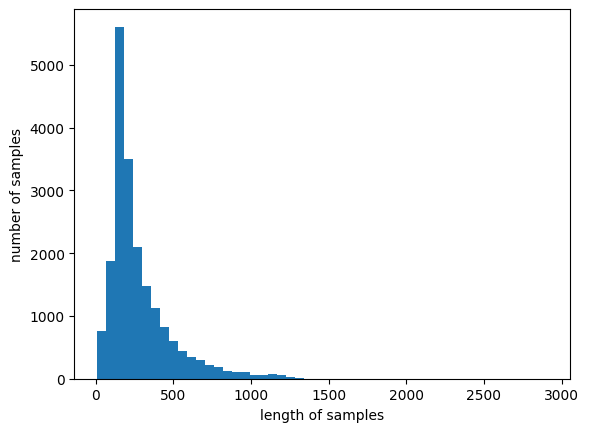

In [73]:
print('리뷰의 최대 길이: ', max(len(review) for review in encoded_X_train))
print('리뷰의 평균길이: ', sum(map(len, encoded_X_train))/len(encoded_X_train))
plt.hist([len(review) for review in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

 그래프를 봤을 때 전체 데이터의 길이 분포는 대체적으로 약 1,000내외의 길이를 가지는 것을 볼 수 있습니다. 모델이 처리할 수 있도록 encoded_X_train과 encoded_X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있습니다. 특정 길이 변수를 max_len으로 정합니다. 대부분의 리뷰가 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값은 몇일까요? 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수를 만듭니다.

In [74]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sent in nested_list:
    if(len(sent) <= max_len):
      count = count +1

  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

최대 길이 2,911로 모든 샘플을 패딩하는 것은 조금 과한 처사일 것입니다. 500으로 할 경우 몇 개의 샘플을 손상시키지 않는지 확인해봅시다.

In [75]:
max_len = 500
below_threshold_len(max_len, encoded_X_train)

전체 샘플 중 길이가 500 이하인 샘플의 비율: 87.885


500으로 패딩할 경우 약 88%의 샘플은 그대로 보존됩니다. 더 많은 샘플을 보존하기 위해서는 500보다 더 큰 길이로 패딩할 수도 있겠지만, 여기서는 500으로 진행해보겠습니다. 이를 위해 패딩을 해주는 함수 pad_sequences()를 구현합니다. 해당 함수는 최대 길이를 정하면 해당 길이보다 긴 데이터는 뒷 부분을 잘라서 해당 길이로 맞추고, 해당 길이보다 짧은 데이터는 뒤에 0을 채워서 해당 길이의 데이터로 변환합니다. 결과적으로 길이 500으로 패딩을 하면 모든 데이터의 길이는 500이 됩니다.

In [76]:
def pad_sequences(sentences, max_len):
  features = np.zeros((len(sentences), max_len),dtype=int)
  for index, sentence in enumerate(sentences):
    features[index, :len(sentence)] = np.array(sentence)[:max_len]

  return features

padded_X_train = pad_sequences(encoded_X_train, max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len)

print('훈련 데이터의 크기: ',padded_X_train.shape)
print('검증 데이터의 크기: ', padded_X_valid.shape)
print('테스트 데이터의 크기: ', padded_X_test.shape)

훈련 데이터의 크기:  (20000, 500)
검증 데이터의 크기:  (5000, 500)
테스트 데이터의 크기:  (25000, 500)


## 모델링
이제 딥 러닝 프레임워크 PyTorch를 이용하여 GRU 모델을 구현해봅시다.

In [77]:
import torch
import torch.nn as nn
import torch.functional as F

In [78]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", device)

cpu와 cuda 중 다음 기기로 학습함: cuda


저자의 경우 Colab에서 GPU를 선택하여 실습을 진행하여 cuda라는 출력 결과를 확인했습니다. 레이블 데이터를 파이토치의 텐서 타입으로 변환합니다. 이후 훈련 데이터의 상위 5개의 레이블을 출력해보았습니다.

In [79]:
train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))
test_label_tensor = torch.tensor(np.array(y_test))

print(train_label_tensor[:5])

tensor([0, 0, 1, 1, 1])


GRU 모델을 클래스로 구현해봅시다. 각 층을 지날 때마다 각 층의 출력의 크기를 이해하는 것이 중요합니다. 예를 들어 입력은 (배치 크기, 문장 길이)의 크기를 가지는 텐서입니다. 임베딩 층을 지나고 나면 각 단어가 임베딩 벡터로 변환되면서 (배치 크기, 문장 길이, 임베딩 벡터의 차원)으로 텐서의 크기가 변환됩니다.

이 후 GRU의 마지막 시점의 은닉 상태(hidden state) 값을 출력층과 연결시키는 작업을 해주어야 합니다. 이때 GRU가 출력층으로 보는 결과값의 차원은 (배치 크기, 은닉 상태의 차원)을 가져야 합니다. 마지막 시점의 은닉 상태의 값만 전달하므로 은닉 상태는 모든 시점(문장 길이)만큼 존재하는 것이 아니라 단 하나만 있습니다. 출력층은 지난 결과는 소프트맥스 회귀를 수행하므로 (배치 크기, 분류하고자하는 카테고리의 수)의 차원을 가지게 됩니다.

그 후 각 데이터를 배치 단위로 데이터 묶음을 꺼낼 수 있는 데이터로더로 전달합니다. 정리하면 다음과 같습니다. 아직 모델을 만들지는 않았지만, 단어 벡터의 차원을 100, 배치 크기를 32, 문장 길이를 500(패딩 후), GRU의 은닉 상태의 차원을 128로 한다고 가정해보겠습니다.

- 단어 벡터의 차원 = 100
- 문장 길이 = 500
- 배치 크기 = 32
- 데이터 개수 = 2만
- GRU의 은닉층의 크기 = 128
- 분류하고자 하는 카테고리 개수 = 2개

위의 정보들을 고려하였을 때 모델 내부에서 데이터의 변화는 다음과 같습니다.

(32, 500) => 입력 데이터의 형태 => 임베딩 층 통과 후 => (32, 500, 100) => GRU 통과 후 => (32, 128) => Softmax 출력층 통과 후 => (32, 2)

In [81]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
    super(TextClassifier, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    embedded = self.embedding(x)
    gru_out, hidden = self.gru(embedded)
    last_hidden = hidden.squeeze(0)
    logits = self.fc(last_hidden)
    return logits

훈련 데이터, 검증 데이터, 테스트 데이터에 대해서 파이토치 텐서로 변환하고 배치 단위 연산을 위해 데이터로더로 변환합니다.

In [82]:
encoded_train = torch.tensor(padded_X_train).to(torch.int64)
train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size =1)

encoded_test = torch.tensor(padded_X_test).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=1)

훈련 데이터의 샘플 개수가 20,000개 였으므로 배치 크기를 32로 할 경우에는 20000/32=625 다시 말해 32개씩 묶인 데이터 묶음이 625개가 생깁니다. 그리고 학습 시에는 32개씩 데이터가 들어가게 될 것입니다.

In [83]:
total_batch = len(train_dataloader)
print('총 배치의 수: ', total_batch)

총 배치의 수:  625


In [84]:
# 모델 객체를 선언합니다.
embedding_dim = 100
hidden_dim = 128
output_dim = 2
learning_rate = 0.01
num_epochs = 10

model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
model.to(device)

TextClassifier(
  (embedding): Embedding(38711, 100)
  (gru): GRU(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

임베딩 벡터의 차원은 128, 출력층의 크기(분류해야 할 카테고리의 개수)는 2로 정했습니다. 이렇게 사용자가 정해주는 값이면서 모델의 결과에 영향을 미치는 값들을 하이퍼파라미터라고 합니다. 소프트맥스 회귀를 통해 분류 문제를 진행하므로 손실 함수는 nn.CrossEntropyLoss()를 사용합니다. 파이토치로 자연어 처리를 하게 되면 가장 많이 사용하게 되는 손실 함수입니다. 하이퍼파라미터 중 하나인 학습률(learning rate)는 0.001로 정했습니다.

In [85]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 6. 평가 코드 작성
이후 평가를 진행하기 위해서 모델의 정확도를 측정하는 함수 calculate_accuracy()를 작성합니다.

In [86]:
def calculate_accuracy(logits, labels):
    # _, predicted = torch.max(logits, 1)
    predicted = torch.argmax(logits, dim=1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy


검증 데이터와 테스트 데이터에 대한 성능을 측정하기 위한 함수 evaluate()를 작성합니다. 아래의 함수에서 model.eval()과 with torch.no_grad()를 짚어봅시다. 이 두 개는 모델 평가를 수행할 때 중요한 역할을 합니다. 각각의 의미는 다음과 같습니다.


model.eval(): 모델을 평가 모드로 설정합니다. 이렇게 하면 모델 내부의 모든 레이어에 대해 평가 모드가 활성화됩니다. 일부 레이어, 예를 들어 드롭아웃이나 배치 정규화는 학습과 평가 시 다르게 동작하기 때문에 이 설정이 중요합니다. 평가 모드가 설정되지 않으면, 이러한 레이어의 동작이 올바르지 않을 수 있으며, 이로 인해 평가 결과가 제대로 나오지 않을 수 있습니다.

with torch.no_grad(): 이 문장은 자동 미분 엔진에서 기울기(gradient) 계산을 비활성화합니다. 평가 중에는 기울기를 계산할 필요가 없으므로, 이렇게 설정하면 메모리를 절약하고 속도를 높일 수 있습니다. 만약 이 설정이 적용되지 않으면, 평가 과정에서 기울기(gradient)가 계산되고 메모리를 차지하게 됩니다. 그러나 평가 결과 자체에는 직접적인 영향을 주지 않습니다.

따라서 model.eval()은 평가 시 반드시 사용해야 하며, 그렇지 않으면 평가 결과가 올바르게 나오지 않을 수 있습니다. with torch.no_grad():는 필수는 아니지만, 메모리와 속도 측면에서 권장됩니다.

In [87]:
def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        # 데이터로더로부터 배치 크기만큼의 데이터를 연속으로 로드
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 모델의 예측값
            logits = model(batch_X)

            # 손실을 계산
            loss = criterion(logits, batch_y)

            # 정확도와 손실을 계산함
            val_loss += loss.item()
            val_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy


## 7. 학습
이제 모델을 학습해봅시다. 딥러닝 모델을 훈련하고 검증하는 과정을 반복하며, 검증 손실이 개선될 때마다 모델의 가중치를 저장합니다. 각 에포크마다 훈련 손실과 정확도를 계산하고, 검증 데이터로 모델을 평가합니다. 검증 손실이 가장 낮은 경우 해당 모델의 가중치를 파일로 저장합니다.

In [88]:
num_epochs = 5  # 총 학습을 몇 번 반복할 것인지 설정하는 변수, 여기서는 5번 반복합니다.

# Training loop
best_val_loss = float('inf')  # 검증 손실의 최저 값을 추적하기 위한 변수로, 초기값은 매우 큰 값으로 설정합니다.

# Training loop
for epoch in range(num_epochs):  # 설정된 에포크 수만큼 반복합니다.
    # Training
    train_loss = 0  # 에포크 동안의 전체 훈련 손실을 저장할 변수입니다.
    train_correct = 0  # 에포크 동안 올바르게 예측된 샘플의 수를 저장할 변수입니다.
    train_total = 0  # 에포크 동안 처리된 총 샘플 수를 저장할 변수입니다.
    model.train()  # 모델을 훈련 모드로 설정합니다.

    for batch_X, batch_y in train_dataloader:  # 훈련 데이터셋을 배치 단위로 반복합니다.
        # Forward pass
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # 배치 데이터를 GPU와 같은 장치에 올립니다.
        # batch_X.shape == (batch_size, max_len)
        logits = model(batch_X)  # 모델에 입력 데이터를 넣어 예측값(logits)을 계산합니다.

        # Compute loss
        loss = criterion(logits, batch_y)  # 예측값과 실제 값 간의 손실(loss)을 계산합니다.

        # Backward pass and optimization
        optimizer.zero_grad()  # 이전 배치에서 계산된 기울기(gradient)를 초기화합니다.
        loss.backward()  # 역전파를 통해 기울기를 계산합니다.
        optimizer.step()  # 계산된 기울기를 사용하여 모델의 파라미터를 업데이트합니다.

        # Calculate training accuracy and loss
        train_loss += loss.item()  # 현재 배치의 손실을 전체 훈련 손실에 추가합니다.
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)  # 정확도를 계산하여 올바르게 예측된 샘플 수를 추가합니다.
        train_total += batch_y.size(0)  # 현재 배치의 샘플 수를 전체 샘플 수에 추가합니다.

    train_accuracy = train_correct / train_total  # 전체 훈련 데이터에 대한 정확도를 계산합니다.
    train_loss /= len(train_dataloader)  # 배치 수로 나누어 평균 훈련 손실을 계산합니다.

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)  # 검증 데이터로 모델을 평가하여 손실과 정확도를 계산합니다.

    print(f'Epoch {epoch+1}/{num_epochs}:')  # 현재 에포크 번호와 총 에포크 수를 출력합니다.
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')  # 훈련 손실과 정확도를 출력합니다.
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')  # 검증 손실과 정확도를 출력합니다.

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:  # 현재 검증 손실이 이전의 최저 손실보다 낮으면
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')  # 손실이 개선되었음을 출력합니다.
        best_val_loss = val_loss  # 최저 검증 손실을 현재 손실로 업데이트합니다.
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')  # 현재 모델의 가중치를 파일로 저장합니다.


Epoch 1/5:
Train Loss: 0.6980, Train Accuracy: 0.5027
Validation Loss: 0.6940, Validation Accuracy: 0.5094
Validation loss improved from inf to 0.6940. 체크포인트를 저장합니다.
Epoch 2/5:
Train Loss: 0.6912, Train Accuracy: 0.5157
Validation Loss: 0.7015, Validation Accuracy: 0.4984
Epoch 3/5:
Train Loss: 0.6740, Train Accuracy: 0.5506
Validation Loss: 0.6555, Validation Accuracy: 0.6356
Validation loss improved from 0.6940 to 0.6555. 체크포인트를 저장합니다.
Epoch 4/5:
Train Loss: 0.5579, Train Accuracy: 0.7244
Validation Loss: 0.6317, Validation Accuracy: 0.6658
Validation loss improved from 0.6555 to 0.6317. 체크포인트를 저장합니다.
Epoch 5/5:
Train Loss: 0.3570, Train Accuracy: 0.8504
Validation Loss: 0.3584, Validation Accuracy: 0.8516
Validation loss improved from 0.6317 to 0.3584. 체크포인트를 저장합니다.


num_epochs라는 변수를 통해 훈련을 몇 번 반복할지를 설정하며, 여기서는 5번의 반복을 수행합니다.

best_val_loss는 모델의 검증 손실 중 가장 낮은 값을 추적하는 변수입니다. 초기값은 매우 큰 값으로 설정되며, 검증 손실이 이 값보다 작으면 모델의 상태를 저장합니다.

훈련 과정에서 train_dataloader는 데이터를 배치로 묶어 모델에 입력합니다. 각 배치마다 배치 데이터(batch_X, batch_y)를 device(보통 GPU)에 올려서 모델에 입력하고, 모델로부터 예측값(logits)을 계산합니다. 이후 예측값과 실제 정답(batch_y) 사이의 손실을 계산하고, 이를 바탕으로 역전파를 통해 모델의 가중치를 업데이트합니다.

훈련이 끝나면, 훈련 손실과 정확도를 계산하고 이를 출력합니다. 검증 과정에서는 모델을 valid_dataloader로 평가하고, 검증 손실과 검증 정확도를 계산합니다. 검증 손실이 이전 최저 검증 손실보다 낮다면, 새로운 최저 검증 손실로 업데이트하고 해당 상태의 모델 가중치를 저장합니다.

이 과정은 전체 에포크 동안 반복되며, 최종적으로 성능이 가장 좋은 모델의 가중치가 저장됩니다.

## 8. 모델 로드 및 평가
이제 베스트 모델을 로드하여 테스트 데이터에 대한 성능을 측정해 봅시다.

In [ ]:
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# 모델을 device에 올립니다.
model.to(device)

evaluate() 함수를 이용하여 검증 데이터에 대한 정확도와 손실을 출력해봅시다

In [89]:
# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')


Best model validation loss: 0.3584
Best model validation accuracy: 0.8516


검증 데이터에 대한 정확도는 85.16%입니다. 이제 테스트 데이터에 대한 정확도와 손실을 출력해봅시다.

In [90]:
# 테스트 데이터에 대한 정확도와 손실 계산
test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

print(f'Best model test loss: {test_loss:.4f}')
print(f'Best model test accuracy: {test_accuracy:.4f}')


Best model test loss: 0.3581
Best model test accuracy: 0.8465


테스트 데이터에 대한 정확도는 84.65%입니다.

## 9. 모델 테스트
이제 임의의 입력에 대해서 예측을 하는 predict() 함수를 만듭니다.

In [91]:
index_to_tag = {0 : '부정', 1 : '긍정'}

def predict(text, model, word_to_index, index_to_tag):
    # 모델 평가 모드
    model.eval()

    # 토큰화 및 정수 인코딩. OOV 문제 발생 시 <UNK> 토큰에 해당하는 인덱스 1 할당
    tokens = word_tokenize(text)
    token_indices = [word_to_index.get(token.lower(), 1) for token in tokens]

    # 리스트를 텐서로 변경
    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)  # (1, seq_length)

    # 모델의 예측
    with torch.no_grad():
        logits = model(input_tensor)  # (1, output_dim)

    # 레이블 인덱스 예측
    _, predicted_index = torch.max(logits, dim=1)  # (1,)

    # 인덱스와 매칭되는 카테고리 문자열로 변경
    predicted_tag = index_to_tag[predicted_index.item()]

    return predicted_tag


먼저 model.eval()은 모델을 평가 모드로 전환합니다. 이 단계에서는 모델이 예측을 할 때 학습과정에서 사용되었던 드롭아웃 같은 기능이 비활성화됩니다. 텍스트는 word_tokenize 함수를 사용해 단어 단위로 분리되며, 각 단어는 소문자로 변환된 후 사전에 정의된 word_to_index 사전에서 해당 단어의 인덱스를 찾아 정수로 변환됩니다. 만약 사전에 없는 단어가 발견되면, 해당 단어는 로 처리되어 인덱스 1이 할당됩니다.

변환된 정수 인덱스 리스트는 PyTorch 텐서로 변환되어 모델에 입력됩니다. 이 텐서는 배치 크기가 1인 2차원 텐서로, 입력 텍스트의 각 단어가 인덱스로 변환된 결과를 담고 있습니다. with torch.no_grad() 구문은 모델의 예측 과정에서 기울기 계산을 비활성화하여 메모리와 연산 속도를 최적화합니다. 이로써 입력된 텍스트에 대해 모델의 예측값을 계산합니다.

모델의 출력인 logits는 각 감정 클래스에 대한 점수로, 이 중에서 가장 높은 점수를 가진 인덱스가 예측된 감정 클래스로 선택됩니다. 이 인덱스는 index_to_tag 사전을 통해 '긍정' 또는 '부정'이라는 문자열로 변환됩니다. 최종적으로 예측된 감정 클래스를 반환합니다.

이제 임의의 입력에 대해서 예측을 해봅시다. 영화에 대한 부정적인 리뷰를 predict() 함수의 입력으로 사용해봅시다.

In [92]:
test_input = "This movie was just way too overrated. The fighting was not professional and in slow motion. I was expecting more from a 200 million budget movie. The little sister of T.Challa was just trying too hard to be funny. The story was really dumb as well. Don't watch this movie if you are going because others say its great unless you are a Black Panther fan or Marvels fan."

predict(test_input, model, word_to_index, index_to_tag)


'부정'

In [93]:
test_input = " I was lucky enough to be included in the group to see the advanced screening in Melbourne on the 15th of April, 2012. And, firstly, I need to say a big thank-you to Disney and Marvel Studios. Now, the film... how can I even begin to explain how I feel about this film? It is, as the title of this review says a 'comic book triumph'. I went into the film with very, very high expectations and I was not disappointed. Seeing Joss Whedon's direction and envisioning of the film come to life on the big screen is perfect. The script is amazingly detailed and laced with sharp wit a humor. The special effects are literally mind-blowing and the action scenes are both hard-hitting and beautifully choreographed."

predict(test_input, model, word_to_index, index_to_tag)


'긍정'